In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from joblib import load, dump, Parallel, delayed
from tqdm import tqdm
import random

In [2]:
satellite_path = r"C:\Users\mouni\Downloads\ims.np\ims.np"
mask_path = r"C:\Users\mouni\Downloads\mas.np\mas.np"
output_dir = "processed_data"
resize_shape = (128, 128)
test_split = 0.2
os.makedirs(output_dir, exist_ok=True)

# Create folders for saving images
sat_img_dir = os.path.join(output_dir, "satellite_images")
mask_img_dir = os.path.join(output_dir, "mask_images")
os.makedirs(sat_img_dir, exist_ok=True)
os.makedirs(mask_img_dir, exist_ok=True)

In [3]:
def safe_load(path):
    ext = os.path.splitext(path)[1]
    try:
        if ext in [".joblib", ".pkl", ".np"]:
            data = load(path)
        elif ext == ".npz":
            data = np.load(path, allow_pickle=True)['arr_0']
        elif ext == ".npy":
            data = np.load(path, allow_pickle=True)
        else:
            raise ValueError("Unsupported file format")
        print(f"✅ Loaded {path} | Shape: {data.shape}")
        return data
    except Exception as e:
        print(f"❌ Failed to load {path}: {e}")
        return None

In [4]:
satellite = safe_load(satellite_path)
masked = safe_load(mask_path)

if satellite is None or masked is None:
    raise ValueError("Failed to load one or both datasets.")

if len(masked.shape) == 3:
    masked = np.expand_dims(masked, axis=-1)

assert satellite.shape[0] == masked.shape[0], "Image & mask count mismatch!"

✅ Loaded C:\Users\mouni\Downloads\ims.np\ims.np | Shape: (1260, 1024, 1024, 4)
✅ Loaded C:\Users\mouni\Downloads\mas.np\mas.np | Shape: (1260, 1024, 1024)


In [5]:
def resize_pair(img, mask):
    img_resized = cv2.resize(img, resize_shape)
    mask_resized = cv2.resize(mask, resize_shape)
    return img_resized, mask_resized

print("🔄 Resizing images using Joblib parallel processing...")
results = Parallel(n_jobs=-1, prefer="threads")(
    delayed(resize_pair)(satellite[i], masked[i]) for i in range(len(satellite))
)
X_resized, Y_resized = zip(*results)
X_resized = np.array(X_resized, dtype=np.float32)
Y_resized = np.array(Y_resized, dtype=np.float32)
print(f"✅ Resized to {resize_shape}, Total: {len(X_resized)}")

🔄 Resizing images using Joblib parallel processing...
✅ Resized to (128, 128), Total: 1260


In [6]:
X_resized /= 255.0
Y_resized /= 255.0

In [7]:
non_blank_idx = [i for i, m in enumerate(Y_resized) if np.sum(m) > 0]
X_resized = X_resized[non_blank_idx]
Y_resized = Y_resized[non_blank_idx]
print(f"✅ Removed blank masks | Remaining: {len(X_resized)}")

✅ Removed blank masks | Remaining: 1245


C:\Users\mouni\AppData\Local\Temp\ipykernel_13532\2857794221.py:12: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\mouni\Downloads\Satillite_Images\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


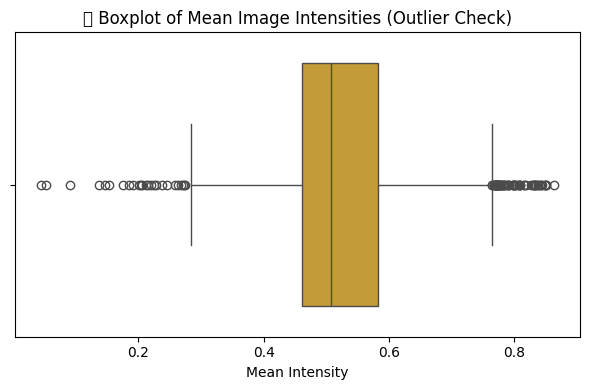

In [8]:
# ================= OUTLIER DETECTION =================
brightness = X_resized.mean(axis=(1,2,3))

# Sharpness via Laplacian variance
sharpness = np.array([cv2.Laplacian((img * 255).astype('uint8'), cv2.CV_64F).var() for img in X_resized])

# --- Histograms instead of Boxplots ---
plt.figure(figsize=(6, 4))
sns.boxplot(x=brightness, color='goldenrod')
plt.title("📦 Boxplot of Mean Image Intensities (Outlier Check)")
plt.xlabel("Mean Intensity")
plt.tight_layout()
plt.show()


In [9]:

# --- Outlier removal ---
def remove_outliers(values, low=25, high=75):
    Q1, Q3 = np.percentile(values, [low, high])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return (values >= lower) & (values <= upper)

valid_idx = remove_outliers(brightness) & remove_outliers(sharpness)
X_resized = X_resized[valid_idx]
Y_resized = Y_resized[valid_idx]
print(f"✅ Removed brightness & sharpness outliers | Remaining: {len(X_resized)}")

✅ Removed brightness & sharpness outliers | Remaining: 1148


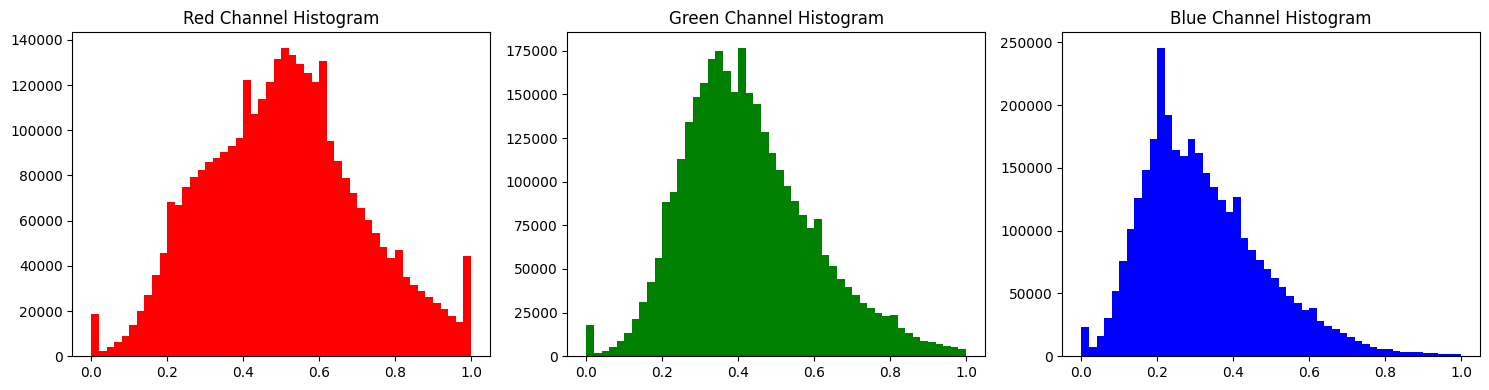

In [10]:
channels = ['Red', 'Green', 'Blue']
plt.figure(figsize=(15,4))
for i, color in enumerate(channels):
    plt.subplot(1,3,i+1)
    plt.hist(X_resized[:200, :, :, i].ravel(), bins=50, color=color.lower())
    plt.title(f'{color} Channel Histogram')
plt.tight_layout()
plt.show()

🖼️ Showing sample before/after images...


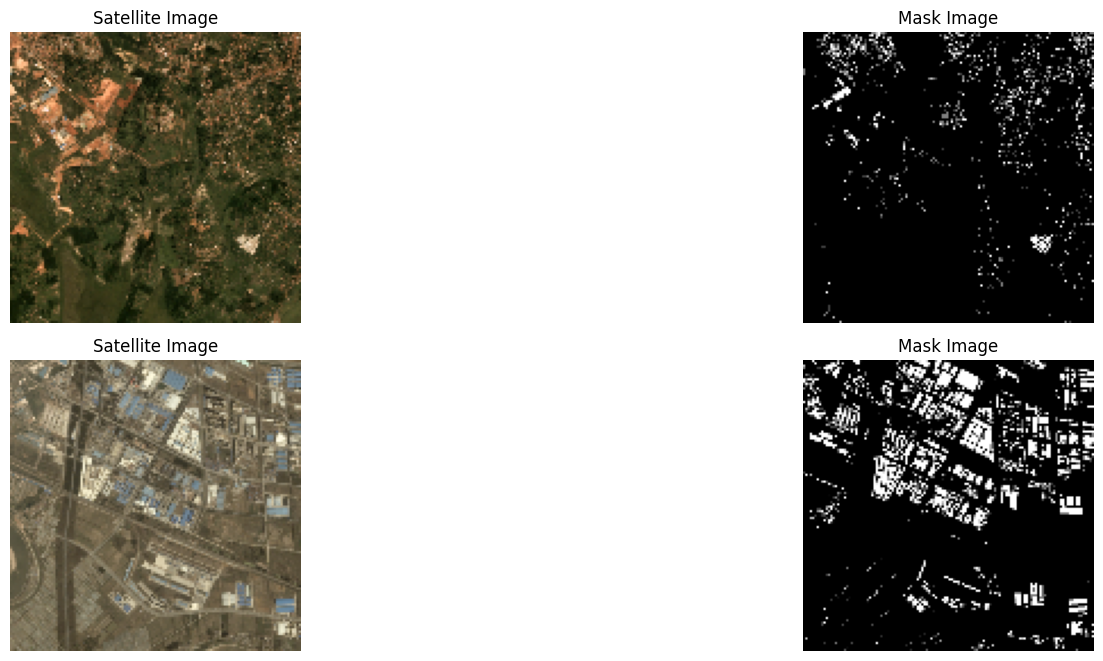

In [11]:
# ================= SAMPLE VISUALIZATION =================
print("🖼️ Showing sample before/after images...")
plt.figure(figsize=(16, 10))
for i in range(2):
    idx = random.randint(0, len(X_resized)-1)
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(X_resized[idx])
    plt.title("Satellite Image")
    plt.axis("off")

    plt.subplot(3, 2, 2*i+2)
    plt.imshow(Y_resized[idx].squeeze(), cmap='gray')
    plt.title("Mask Image")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
print("💾 Saving preprocessed images to disk as PNG files...")

for i in tqdm(range(len(X_resized))):
    sat_img = (X_resized[i] * 255).astype(np.uint8)
    mask_img = (Y_resized[i].squeeze() * 255).astype(np.uint8)

    sat_filename = os.path.join(sat_img_dir, f"{i:04d}.png")
    mask_filename = os.path.join(mask_img_dir, f"{i:04d}.png")

    cv2.imwrite(sat_filename, cv2.cvtColor(sat_img, cv2.COLOR_RGB2BGR))  # Convert to BGR for OpenCV
    cv2.imwrite(mask_filename, mask_img)

print(f"✅ Saved {len(X_resized)} satellite and mask images as PNGs.")

💾 Saving preprocessed images to disk as PNG files...


100%|██████████| 1148/1148 [00:03<00:00, 316.56it/s]

✅ Saved 1148 satellite and mask images as PNGs.


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resized, Y_resized, test_size=test_split, random_state=42
)
print(f"✅ Train/Test split | Train: {X_train.shape} | Test: {X_test.shape}")

✅ Train/Test split | Train: (918, 128, 128, 4) | Test: (230, 128, 128, 4)



🔗 Creating channel correlation heatmap...


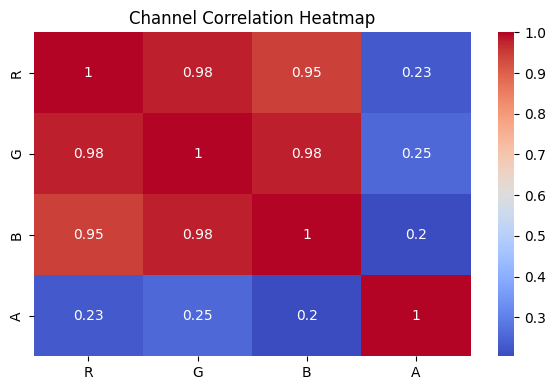

In [14]:
if X_train.shape[3] >= 3:
    print("\n🔗 Creating channel correlation heatmap...")
    reshaped = X_train.reshape(-1, X_train.shape[3])
    corr = np.corrcoef(reshaped.T)
    plt.figure(figsize=(6, 4))
    num_channels = X_train.shape[3]
    channel_labels = ['R', 'G', 'B', 'A'][:num_channels]
    sns.heatmap(corr, annot=True, cmap="coolwarm",
                xticklabels=channel_labels,
                yticklabels=channel_labels)
    plt.title("Channel Correlation Heatmap")
    plt.tight_layout()
    plt.show()

In [15]:
print("\n === PREPROCESSING SUMMARY ===")
print(f"Total original images loaded: {len(satellite)}")
print(f"After blank masks removal: {len(non_blank_idx)}")
print(f"After outlier removal: {len(X_resized)}")
print(f"Saved satellite images to: {sat_img_dir}")
print(f"Saved mask images to:      {mask_img_dir}")
print(f"Train set size: {X_train.shape}")
print(f"Test set size:  {X_test.shape}")


 === PREPROCESSING SUMMARY ===
Total original images loaded: 1260
After blank masks removal: 1245
After outlier removal: 1148
Saved satellite images to: processed_data\satellite_images
Saved mask images to:      processed_data\mask_images
Train set size: (918, 128, 128, 4)
Test set size:  (230, 128, 128, 4)


✅ Train/Test split | Train: (918, 128, 128, 4) | Test: (230, 128, 128, 4)


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,055,873 (118.47 MB)

 Trainable params: 31,044,097 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.7733 - loss: 0.6135 - val_accuracy: 0.8873 - val_loss: 0.9933
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.8249 - loss: 0.5609 - val_accuracy: 0.8873 - val_loss: 0.9970
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.8384 - loss: 0.5415 - val_accuracy: 0.6350 - val_loss: 0.8382
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.8462 - loss: 0.5311 - val_accuracy: 0.8873 - val_loss: 0.9992
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8504 - loss: 0.5248 - val_accuracy: 0.8876 - val_loss: 0.9912
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8580 - loss: 0.5078 - val_accuracy: 0.8922 - val_loss: 0.8792
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.8654 - loss: 0.4948 - val_accuracy: 0.8678 - val_loss: 0.6805
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 332s 3s/step - accuracy: 0.8697 - loss: 0.4863 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


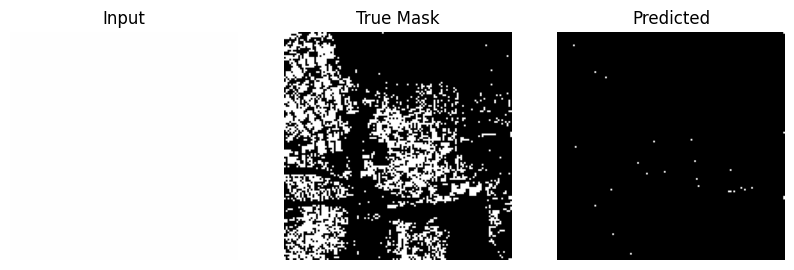

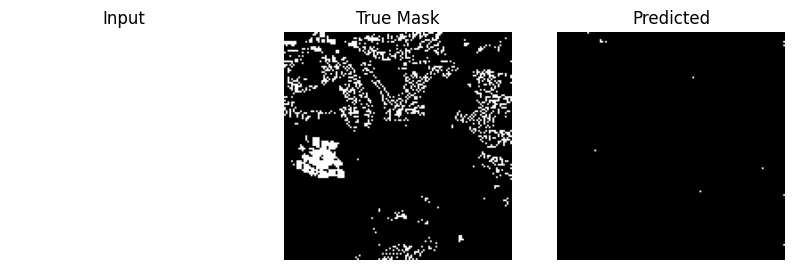

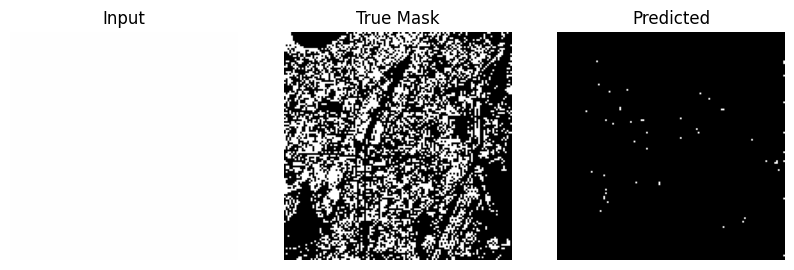

In [16]:
+# -----------------------------------------------------------
# IMPORTS
# -----------------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------
# HYPERPARAMETERS
# -----------------------------------------------------------
IMG_SIZE = (128, 128)
BATCH_SIZE = 8
EPOCHS = 50
NUM_CLASSES = 1  # Binary segmentation

# -----------------------------------------------------------
# PREPROCESSED ARRAYS FROM YOUR PIPELINE
# (Assumes you already have X_resized, Y_resized)
# -----------------------------------------------------------

# Normalize image pixels (0–1)
X_resized = X_resized.astype("float32") / 255.0

# Convert masks to binary (0 or 1)
Y_resized = (Y_resized > 0).astype("float32")

# Train/test split
test_split = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X_resized, Y_resized, test_size=test_split, random_state=42
)
print(f"✅ Train/Test split | Train: {X_train.shape} | Test: {X_test.shape}")

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# -----------------------------------------------------------
# MODEL: UNET
# -----------------------------------------------------------
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(d4)

    model = models.Model(inputs, outputs, name="UNet")
    return model

# -----------------------------------------------------------
# DICE LOSS (better than binary crossentropy for imbalance)
# -----------------------------------------------------------
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1e-7) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-7)

# -----------------------------------------------------------
# COMPILE & TRAIN
# -----------------------------------------------------------
model = build_unet(input_shape=X_train.shape[1:])
model.compile(optimizer="adam", loss=dice_loss, metrics=["accuracy"])
model.summary()

# Save initial untrained model
model.save("initial_unet_model.h5")

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# Save trained model
model.save("trained_unet_model.h5")

# -----------------------------------------------------------
# VISUALIZATION
# -----------------------------------------------------------
def show_predictions(n=3):
    for images, masks in val_ds.take(1):
        preds = model.predict(images)
        for i in range(n):
            img = images[i].numpy()
            true_mask = masks[i].numpy()
            pred_mask = preds[i]  # Already numpy

            plt.figure(figsize=(10,3))

            plt.subplot(1,3,1)
            plt.title("Input")
            plt.imshow(img)
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.title("True Mask")
            plt.imshow(np.squeeze(true_mask), cmap="gray")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.title("Predicted")
            plt.imshow(np.squeeze(pred_mask) > 0.5, cmap="gray")
            plt.axis("off")

            plt.show()

# Show predictions
show_predictions(3)


In [15]:
# -----------------------------------------------------------
# IMPORTS
# -----------------------------------------------------------
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------------
# CUSTOM LOSS (for loading model)
# -----------------------------------------------------------
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1e-7) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-7
    )

# -----------------------------------------------------------
# LOAD TRAINED MODEL
# -----------------------------------------------------------
model = load_model("trained_unet_model.h5", custom_objects={"dice_loss": dice_loss})
print("✅ Model loaded successfully!")

# -----------------------------------------------------------
# SETTINGS
# -----------------------------------------------------------
IMG_SIZE = (128, 128)
TEST_DIR = "test_images"
MASK_DIR = "test_masks"           # optional (ground truth masks)
SAVE_DIR = "predicted_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# -----------------------------------------------------------
# METRIC FUNCTIONS
# -----------------------------------------------------------
def dice_score(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-7)

def iou_score(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

# -----------------------------------------------------------
# PREDICTION & COMPARISON FUNCTION
# -----------------------------------------------------------
def predict_and_compare(image_path, mask_path=None):
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype("float32") / 255.0

    # Add 4th channel if missing
    if img.shape[-1] == 3:
        fourth_channel = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32)
        img = np.concatenate([img, fourth_channel], axis=-1)

    img_input = np.expand_dims(img, axis=0)

    # Predict mask
    pred = model.predict(img_input, verbose=0)[0]
    pred_mask = (pred > 0.5).astype("uint8")

    # Load true mask (optional)
    true_mask = None
    dice, iou = None, None
    if mask_path and os.path.exists(mask_path):
        true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        true_mask = cv2.resize(true_mask, IMG_SIZE)
        true_mask = (true_mask > 127).astype("uint8")

        # Compute metrics
        dice = dice_score(true_mask, pred_mask.squeeze())
        iou = iou_score(true_mask, pred_mask.squeeze())

    # -----------------------------------------------------------
    # DISPLAY COMPARISON
    # -----------------------------------------------------------
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img[..., :3])
    plt.axis("off")

    if true_mask is not None:
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(true_mask, cmap="gray")
        plt.axis("off")

    plt.subplot(1, 3, 3 if true_mask is not None else 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.axis("off")

    # Add metrics in title
    if dice is not None and iou is not None:
        plt.suptitle(f"Dice: {dice:.3f} | IoU: {iou:.3f}", fontsize=12, color="darkgreen")

    # Save
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    save_path = os.path.join(SAVE_DIR, f"{base_name}_comparison.png")
    plt.savefig(save_path)
    plt.close()
    print(f"🖼️ Saved: {save_path} | Dice={dice:.3f}, IoU={iou:.3f}" if dice else f"🖼️ Saved: {save_path}")

# -----------------------------------------------------------
# RUN ON TEST IMAGES
# -----------------------------------------------------------
if not os.path.exists(TEST_DIR):
    print("⚠️ test_images folder not found.")
else:
    image_files = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(image_files) == 0:
        print("⚠️ No test images found in test_images/")
    else:
        for img_name in image_files:
            img_path = os.path.join(TEST_DIR, img_name)
            mask_path = os.path.join(MASK_DIR, img_name) if os.path.exists(MASK_DIR) else None
            predict_and_compare(img_path, mask_path)


✅ Model loaded successfully!
🖼️ Saved: predicted_results\0947_comparison.png | Dice=0.280, IoU=0.163
🖼️ Saved: predicted_results\0948_comparison.png | Dice=0.183, IoU=0.101
🖼️ Saved: predicted_results\0949_comparison.png | Dice=0.187, IoU=0.103
🖼️ Saved: predicted_results\0950_comparison.png | Dice=0.285, IoU=0.166
🖼️ Saved: predicted_results\0951_comparison.png | Dice=0.269, IoU=0.156
🖼️ Saved: predicted_results\0952_comparison.png | Dice=0.220, IoU=0.123
🖼️ Saved: predicted_results\0953_comparison.png | Dice=0.210, IoU=0.117
🖼️ Saved: predicted_results\0954_comparison.png | Dice=0.255, IoU=0.146
🖼️ Saved: predicted_results\0955_comparison.png | Dice=0.348, IoU=0.211
🖼️ Saved: predicted_results\0956_comparison.png | Dice=0.125, IoU=0.067
🖼️ Saved: predicted_results\0957_comparison.png | Dice=0.235, IoU=0.133
🖼️ Saved: predicted_results\0958_comparison.png | Dice=0.198, IoU=0.110
🖼️ Saved: predicted_results\0959_comparison.png | Dice=0.223, IoU=0.126
🖼️ Saved: predicted_results\0960_co

In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1️⃣ Load the trained U-Net model
model = load_model("trained_unet_model.h5", compile=False)

# 2️⃣ Define helper to get mask and extract features
def extract_features_from_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, (128, 128))

    if img.shape[-1] == 3:
        fourth_channel = np.zeros((128, 128, 1), dtype=img.dtype)
        img = np.concatenate([img, fourth_channel], axis=-1)

    img = img / 255.0
    input_data = np.expand_dims(img, axis=0)

    # Predict segmentation mask
    mask = model.predict(input_data)[0]

    # Since it's a single-channel mask (binary segmentation)
    building_ratio = np.mean(mask[..., 0] > 0.5)

    # You can also include image brightness, color features, etc., later
    return [building_ratio]



# 3️⃣ Prepare training data for classifier
image_folder = r"C:\Users\mouni\Downloads\Satillite_Images\test_images"
labels = []       # 0 = residential, 1 = commercial
features = []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    feats = extract_features_from_image(img_path)
    features.append(feats)

    # Example rule: you must already know which is which
    if "residential" in img_name:
        labels.append(0)
    else:
        labels.append(1)

X = np.array(features)
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weigh

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

def visualize_prediction(img_path):
    # --- Load and preprocess image ---
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img_resized = cv2.resize(img, (128, 128))

    # Add missing 4th channel if needed
    if img_resized.shape[-1] == 3:
        fourth_channel = np.zeros((128, 128, 1), dtype=img_resized.dtype)
        img_resized = np.concatenate([img_resized, fourth_channel], axis=-1)

    img_norm = img_resized / 255.0
    input_data = np.expand_dims(img_norm, axis=0)

    # --- Predict mask using U-Net ---
    mask = model.predict(input_data)[0]
    binary_mask = (mask[..., 0] > 0.5).astype(np.uint8) * 255

    # --- Extract feature and classify ---
    building_ratio = np.mean(mask[..., 0] > 0.5)
    label = clf.predict([[building_ratio]])[0]
    label_name = "Residential" if label == 0 else "Commercial"

    # --- Overlay mask on image for visualization ---
    overlay = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))
    overlay_colored = cv2.applyColorMap(overlay, cv2.COLORMAP_JET)
    combined = cv2.addWeighted(img, 0.6, overlay_colored, 0.4, 0)

    # --- Plot everything ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Satellite Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[..., 0], cmap="gray")
    plt.title("Predicted Segmentation Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {label_name}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


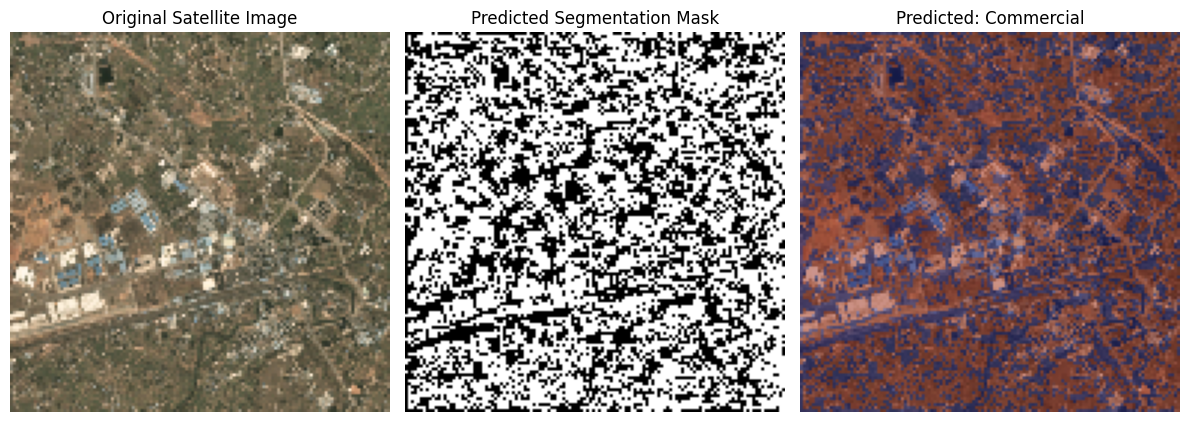

In [16]:
test_img = r"C:\Users\mouni\Downloads\Satillite_Images\test_images\0962.png"
visualize_prediction(test_img)


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Paths
image_folder = r"C:\Users\mouni\Downloads\Satillite_Images\processed_data\satellite_images"
mask_folder = r"C:\Users\mouni\Downloads\Satillite_Images\processed_data\mask_images"

def extract_features_from_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask_resized = cv2.resize(mask, (128, 128))

    # Normalize to 0–1
    mask_resized = mask_resized / 255.0

    # Feature extraction example (adjust based on your mask meaning)
    # Here: compute ratio of built-up vs non-built-up areas
    building_ratio = np.mean(mask_resized > 0.5)

    # You can add more features if your mask has more classes
    return [building_ratio]

# Load features and names
features = []
image_names = []

for img_name in os.listdir(image_folder):
    mask_name = img_name.replace('.jpg', '.png')  # adjust extension if needed
    mask_path = os.path.join(mask_folder, mask_name)
    if not os.path.exists(mask_path):
        continue

    feats = extract_features_from_mask(mask_path)
    features.append(feats)
    image_names.append(img_name)

features = np.array(features)

# Cluster areas (2 clusters: Residential / Commercial)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features)

# Print results
for name, label in zip(image_names, labels):
    area_type = "Residential" if label == 0 else "Commercial"
    print(f"{name} → {area_type}")


0000.png → Residential
0001.png → Residential
0002.png → Residential
0003.png → Residential
0004.png → Residential
0005.png → Residential
0006.png → Residential
0007.png → Residential
0008.png → Residential
0009.png → Residential
0010.png → Residential
0011.png → Residential
0012.png → Residential
0013.png → Residential
0014.png → Residential
0015.png → Residential
0016.png → Residential
0017.png → Residential
0018.png → Residential
0019.png → Residential
0020.png → Residential
0021.png → Residential
0022.png → Residential
0023.png → Residential
0024.png → Residential
0025.png → Residential
0026.png → Residential
0027.png → Residential
0028.png → Residential
0029.png → Residential
0030.png → Residential
0031.png → Residential
0032.png → Residential
0033.png → Residential
0034.png → Residential
0035.png → Residential
0036.png → Residential
0037.png → Residential
0038.png → Residential
0039.png → Residential
0040.png → Residential
0041.png → Residential
0042.png → Residential
0043.png → 

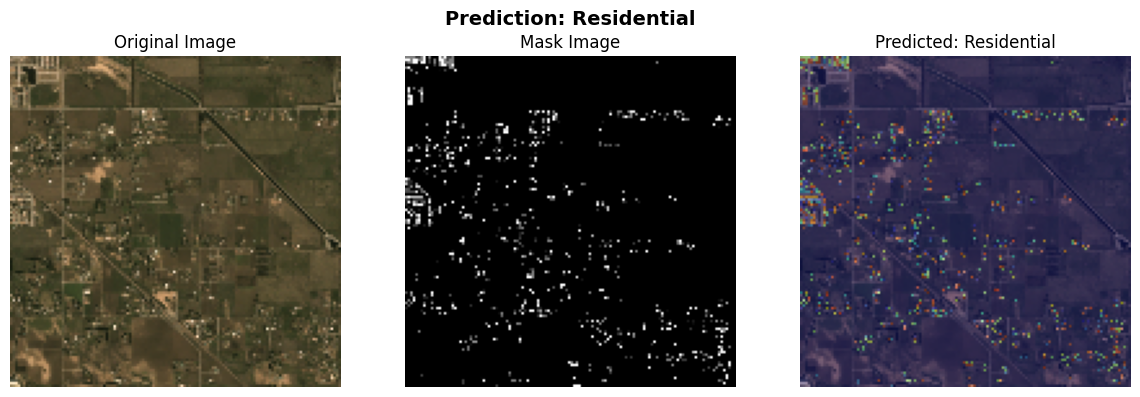

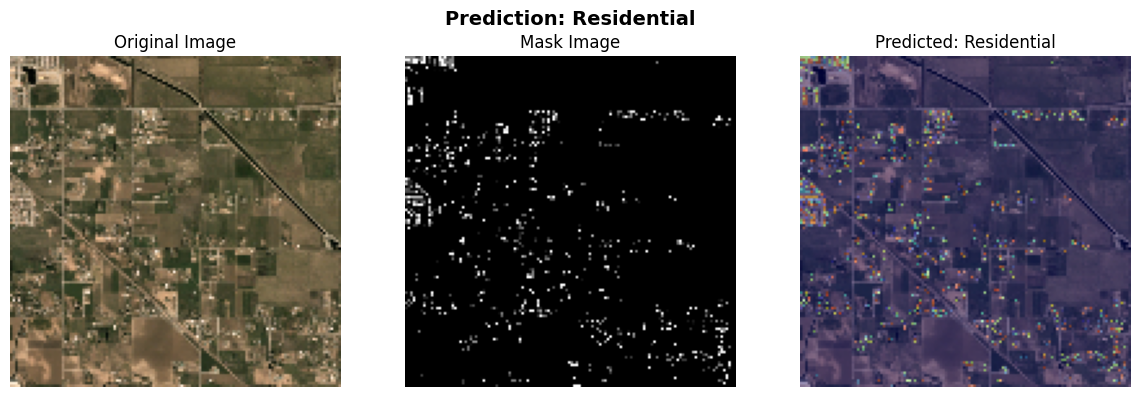

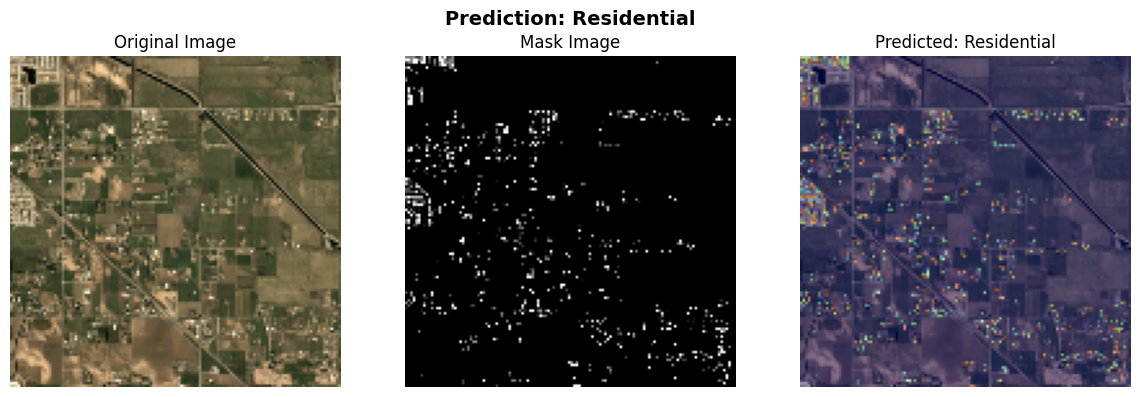

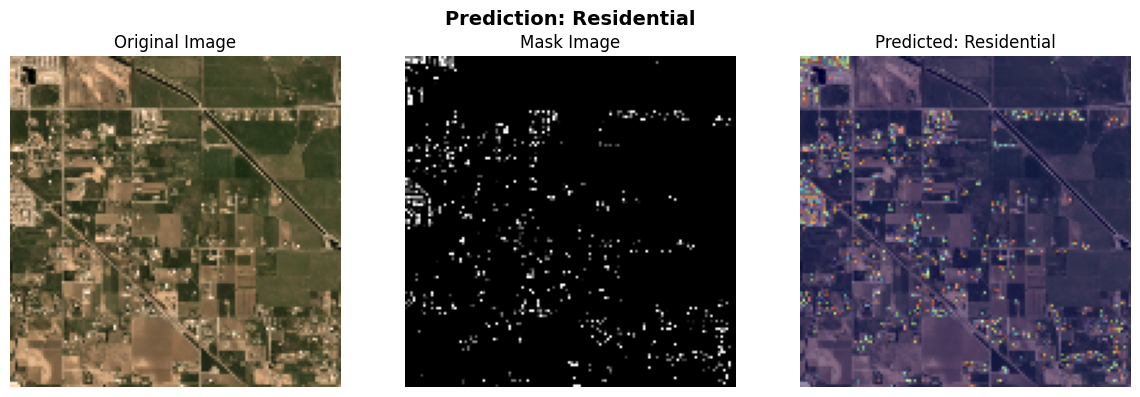

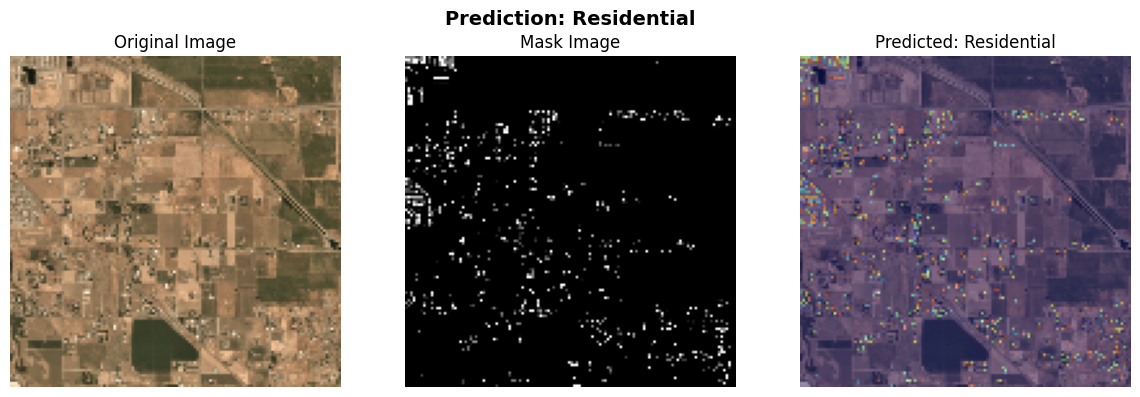

In [8]:
for i, img_name in enumerate(image_names[:5]):  # show first 10 samples
    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, img_name.replace(".jpg", ".png"))

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    binary_mask = mask.copy()
    # Convert color for plotting (BGR → RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Classification result
    label = "Residential" if labels[i] == 0 else "Commercial"
    # --- Overlay mask on image for visualization ---
    overlay = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))
    overlay_colored = cv2.applyColorMap(overlay, cv2.COLORMAP_JET)
    combined = cv2.addWeighted(img, 0.6, overlay_colored, 0.4, 0)
    # Plot all three
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Prediction: {label}", fontsize=14, fontweight="bold")

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    # Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask Image")
    plt.axis("off")

    # Result Display
    result_display = np.zeros_like(img_rgb)
    color = (0, 255, 0) if label == "Residential" else (255, 0, 0)
    result_display[:] = color
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()